In [42]:
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from typing import Annotated, Dict, List, Optional, Sequence, Set
from dataclasses import dataclass, field, replace
from typing_extensions import TypedDict
import re

@dataclass
class InputState:
    """Defines the input state for the agent, representing a narrower interface to the outside world.

    This class is used to define the initial state and structure of incoming data.
    """
    messages : Annotated[Sequence[AnyMessage], add_messages] = field(default_factory=list)
    tables : List[str] = field(default_factory=list)

@dataclass
class AgentState:
    remaining_datafetch: int = 1
    remaining_querygen: int = 3
    question : str = ""
    rewritten_question : str = ""
    updated_question : str = ""
    relevant_queries : List[str] = field(default_factory=list)
    relevant_tables : List[str] = field(default_factory=list)
    relevant_columns : List[str] = field(default_factory=list)
    relevant_tables_columns_reason : str = ""
    already_seen_chunk_column: Set[str] = field(default_factory=set)
    already_seen_chunk_table: Set[str] = field(default_factory=set)
    error_message : str = ""
    explanation : str = ""
    is_sufficient_data : bool = False
    sql_query : str = ""
    query_executed_successfully : bool = False
    result : List[str] =  field(default_factory=list)

@dataclass
class OutputState(TypedDict):
    """Defines the output state for the agent, representing the expected response structure.

    This class is used to define the output format and structure of the agent's response.
    """
    sql_query : str = ""
    explanation : str = ""
    used_tables : List[str] = field(default_factory=list)
    used_columns : List[str] = field(default_factory=list)

In [43]:
##### Question rewriting and generation format class ####
from pydantic import BaseModel, Field
from typing import List

class TableColumnPlan(BaseModel):
    table_name: str = Field(
        ...,
        description="The name of the table that will be used in the SQL query."
    )
    expected_columns: List[str] = Field(
        ...,
        description=(
            "A list of descriptions of the types of data expected from this table. "
            "Do not use exact column names. Instead, describe what kind of information is needed. "
            "Example: 'user ID of the employee', 'Name of the employee', 'name of the skill', 'company identifier', 'Price of the item',etc. This type of short description"
        )
    )
    purpose: str = Field(
        ...,
        description="A short explanation of why this table is needed in the context of answering the query."
    )

class QueryRewritePlan(BaseModel):
    original_question: str = Field(
        ...,
        description="The user's original natural language question."
    )
    rewritten_question: str = Field(
        ...,
        description=(
            "A rewritten version of the original question that clearly explains the intent, "
            "mentions relevant entities, and makes relationships between tables obvious. "
            "This should not be a SQL query, but a detailed version of the natural language question."
        )
    )
    updated_question: str = Field(
        ...,
        description=(
            "An enhanced version of the original question that explicitly mentions what the user "
            "expects to see in the result — including useful fields like names, IDs, totals, etc. "
            "If you think it required filtering or sorting then also mention that data on which you want to filter or sort. "
            "Keep it in plain natural language (no SQL terms), and do not mention specific table or column names."
        )
    )


In [44]:
from typing import Literal
from pydantic import BaseModel, Field

class SQLQueryResponse(BaseModel):
    """
    Structured response for SQL query generation.
    """
    sql_query: str = Field(
        ...,
        description="""The generated SQL query string. the SQL query string wrapped in backticks like:
        ```sql
        SELECT * FROM ... WHERE department = 'Science';
        ```
        If insufficient data, write N/A instead of query."""
    )
    explanation: str = Field(
        ...,
        description="Step-by-step explanation of how the query was created, or if insufficient data, explain what is missing."
    )
    is_sufficient_data: bool = Field(
        ...,
        description="True if all required tables and columns were provided to generate a valid query, else False."
    )

In [45]:
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

def rewrite_question(state : InputState)-> AgentState:
    """Rewrites the user's question to make it more explicit and detailed for SQL planning."""
    question = state.messages[-1].content if state.messages else ""
    tables = state.tables if state.tables else []
    
    prompt = PromptTemplate.from_template("""
    You are a SQL planning assistant.

    Given a user's natural language question:
    1. Rewrite it in a clear, explicit and detailed form that makes all the necessary table and column relationships obvious.
    2. Make sure the rewritten version **asks to display all useful columns**
    3. If the original question is vague (e.g., “top students”), clarify the logic (e.g., “students with the highest average grade”).
    4. Use terminology similar to column or table names when possible (e.g., "student name" instead of "who" or "person").
    5. Identify which tables are required.
    6. For each table, list the descriptions of columns you expect to use and why.
    7. A form that can help a retriever or another AI system better identify relevant tables or columns.
                
    Return your result in the required structured format.
                                        
    ## This are the tables : {table}


    Original Question: {question}
    """)

    
    question_rewrite_chain = prompt | llm.with_structured_output(QueryRewritePlan)
    result = question_rewrite_chain.invoke({
        "question": question,
        "table": tables
    })

    return AgentState(
            remaining_datafetch=1,  # default value
            remaining_querygen=3,   # default value
            question=question,
            rewritten_question=result.rewritten_question,
            updated_question=result.updated_question,
            relevant_queries=[],
            relevant_tables=[],
            relevant_columns=[],
            already_seen_chunk_column=set(),
            already_seen_chunk_table=set(),
            error_message="",
            explanation="",
            is_sufficient_data=False,
            sql_query="",
            query_executed_successfully=False,
            result=[]
        )


In [46]:
tables_descrptions = {
"Departments": "The Departments table holds academic department information. Each department may be associated with multiple students, professors, and courses. Use it when filtering by department or analyzing department-specific activity.",
"Students": "The Students table contains personal and academic enrollment details for students. Each student is associated with a department and can be enrolled in multiple courses. Use this table to filter students by department or analyze student enrollment.",
"Professors": "The Professors table stores data about academic faculty. Each professor belongs to a department and may teach one or more courses. Use this when identifying course instructors or analyzing departmental faculty.",
"Courses": "The Courses table contains the list of academic courses offered by departments. Each course is taught by a professor and belongs to a department. Use it for curriculum planning, instructor assignments, or course scheduling.",
"Enrollments": "The Enrollments table tracks which students are enrolled in which courses, including the date of enrollment. Use it to analyze student course load, popularity of courses, or to join student and course data.",
"Classrooms": "The Classrooms table defines physical classrooms, including building and room number, and capacity. It supports the scheduling system for courses. Use it to analyze classroom utilization or room assignments.",
"Schedules": "The Schedules table links courses to classrooms and timeslots, including day of the week and start/end times. Use it to retrieve timetable information or detect scheduling conflicts.",
"Grades": "The Grades table records student performance in courses by linking enrollment to a grade and grade point. Use it for GPA calculation, performance tracking, and academic reports.",
"Assignments": "The Assignments table contains homework or project records tied to specific courses. Each assignment has a title, due date, and total marks. Use this table for academic workload or submission tracking.",
"Submissions": "The Submissions table tracks which students submitted which assignments and the marks they received. Use this to evaluate assignment performance and submission timing.",
"Clubs": "The Clubs table holds information about student clubs, including their faculty advisor and founding year. Use this when analyzing extracurricular involvement or managing student organizations.",
"ClubMembers": "The ClubMembers table links students to clubs and records their role (e.g., President, Member). Use this table to retrieve club rosters, roles, or member count."
} 

columns_descrptions = {
  "Departments": [
    {
      "column_name": "department_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each academic department."
    },
    {
      "column_name": "department_name",
      "data_type": "TEXT",
      "description": "The name of the department."
    },
    {
      "column_name": "head_of_department_id",
      "data_type": "INTEGER",
      "description": "The ID of the professor who is the head of the department."
    },
    {
      "column_name": "founding_year",
      "data_type": "INTEGER",
      "description": "The year the department was founded."
    }
  ],
  "Students": [
    {
      "column_name": "student_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each student."
    },
    {
      "column_name": "first_name",
      "data_type": "TEXT",
      "description": "The student's first name."
    },
    {
      "column_name": "last_name",
      "data_type": "TEXT",
      "description": "The student's last name."
    },
    {
      "column_name": "email",
      "data_type": "TEXT",
      "description": "The student's email address."
    },
    {
      "column_name": "department_id",
      "data_type": "INTEGER",
      "description": "The ID of the department the student is enrolled in."
    },
    {
      "column_name": "enrollment_date",
      "data_type": "DATE",
      "description": "The date the student was enrolled."
    }
  ],
  "Professors": [
    {
      "column_name": "professor_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each professor."
    },
    {
      "column_name": "first_name",
      "data_type": "TEXT",
      "description": "The professor's first name."
    },
    {
      "column_name": "last_name",
      "data_type": "TEXT",
      "description": "The professor's last name."
    },
    {
      "column_name": "email",
      "data_type": "TEXT",
      "description": "The professor's email address."
    },
    {
      "column_name": "department_id",
      "data_type": "INTEGER",
      "description": "The ID of the department the professor belongs to."
    },
    {
      "column_name": "hire_date",
      "data_type": "DATE",
      "description": "The date the professor was hired."
    },
    {
      "column_name": "salary",
      "data_type": "REAL",
      "description": "The professor's annual salary."
    }
  ],
  "Courses": [
    {
      "column_name": "course_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each course."
    },
    {
      "column_name": "course_name",
      "data_type": "TEXT",
      "description": "The full name of the course."
    },
    {
      "column_name": "course_code",
      "data_type": "TEXT",
      "description": "A unique code for the course."
    },
    {
      "column_name": "department_id",
      "data_type": "INTEGER",
      "description": "The ID of the department that offers the course."
    },
    {
      "column_name": "professor_id",
      "data_type": "INTEGER",
      "description": "The ID of the professor teaching the course."
    },
    {
      "column_name": "credits",
      "data_type": "INTEGER",
      "description": "The number of credits for the course."
    }
  ],
  "Enrollments": [
    {
      "column_name": "enrollment_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each enrollment."
    },
    {
      "column_name": "student_id",
      "data_type": "INTEGER",
      "description": "The ID of the student who is enrolled."
    },
    {
      "column_name": "course_id",
      "data_type": "INTEGER",
      "description": "The ID of the course the student is enrolled in."
    },
    {
      "column_name": "enrollment_date",
      "data_type": "DATE",
      "description": "The date of enrollment."
    }
  ],
  "Classrooms": [
    {
      "column_name": "classroom_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each classroom."
    },
    {
      "column_name": "building",
      "data_type": "TEXT",
      "description": "The building name of the classroom."
    },
    {
      "column_name": "room_number",
      "data_type": "TEXT",
      "description": "The room number of the classroom."
    },
    {
      "column_name": "capacity",
      "data_type": "INTEGER",
      "description": "The maximum capacity of the classroom."
    }
  ],
  "Schedules": [
    {
      "column_name": "schedule_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each schedule entry."
    },
    {
      "column_name": "course_id",
      "data_type": "INTEGER",
      "description": "The ID of the course being scheduled."
    },
    {
      "column_name": "classroom_id",
      "data_type": "INTEGER",
      "description": "The ID of the classroom assigned for the course."
    },
    {
      "column_name": "day_of_week",
      "data_type": "TEXT",
      "description": "The day of the week for the class."
    },
    {
      "column_name": "start_time",
      "data_type": "TIME",
      "description": "The start time of the class."
    },
    {
      "column_name": "end_time",
      "data_type": "TIME",
      "description": "The end time of the class."
    }
  ],
  "Grades": [
    {
      "column_name": "grade_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each grade record."
    },
    {
      "column_name": "enrollment_id",
      "data_type": "INTEGER",
      "description": "The ID of the enrollment record this grade belongs to."
    },
    {
      "column_name": "grade_letter",
      "data_type": "TEXT",
      "description": "The final grade letter (e.g., 'A', 'B+')."
    },
    {
      "column_name": "grade_point",
      "data_type": "REAL",
      "description": "The GPA value for the grade."
    },
    {
      "column_name": "grade_date",
      "data_type": "DATE",
      "description": "The date the grade was issued."
    }
  ],
  "Assignments": [
    {
      "column_name": "assignment_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each assignment."
    },
    {
      "column_name": "course_id",
      "data_type": "INTEGER",
      "description": "The ID of the course the assignment belongs to."
    },
    {
      "column_name": "assignment_title",
      "data_type": "TEXT",
      "description": "The title of the assignment."
    },
    {
      "column_name": "due_date",
      "data_type": "DATE",
      "description": "The due date for the assignment."
    },
    {
      "column_name": "total_marks",
      "data_type": "INTEGER",
      "description": "The maximum marks for the assignment."
    }
  ],
  "Submissions": [
    {
      "column_name": "submission_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each submission."
    },
    {
      "column_name": "assignment_id",
      "data_type": "INTEGER",
      "description": "The ID of the assignment being submitted."
    },
    {
      "column_name": "student_id",
      "data_type": "INTEGER",
      "description": "The ID of the student who submitted the assignment."
    },
    {
      "column_name": "submission_date",
      "data_type": "DATE",
      "description": "The date of the submission."
    },
    {
      "column_name": "marks_obtained",
      "data_type": "INTEGER",
      "description": "The marks the student received on the assignment."
    }
  ],
  "Clubs": [
    {
      "column_name": "club_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each club."
    },
    {
      "column_name": "club_name",
      "data_type": "TEXT",
      "description": "The name of the student club."
    },
    {
      "column_name": "faculty_advisor_id",
      "data_type": "INTEGER",
      "description": "The ID of the professor who advises the club."
    },
    {
      "column_name": "founding_year",
      "data_type": "INTEGER",
      "description": "The year the club was founded."
    }
  ],
  "ClubMembers": [
    {
      "column_name": "member_id",
      "data_type": "INTEGER",
      "description": "Unique identifier for each club member record."
    },
    {
      "column_name": "student_id",
      "data_type": "INTEGER",
      "description": "The ID of the student who is a member of the club."
    },
    {
      "column_name": "club_id",
      "data_type": "INTEGER",
      "description": "The ID of the club the student is a member of."
    },
    {
      "column_name": "role",
      "data_type": "TEXT",
      "description": "The role of the student in the club (e.g., 'President')."
    },
    {
      "column_name": "join_date",
      "data_type": "DATE",
      "description": "The date the student joined the club."
    }
  ]
}


In [47]:

class QueryRewritePlan(BaseModel):
    original_question: str = Field(
        ...,
        description="The user's original natural language question."
    )
    rewritten_question: str = Field(
        ...,
        description=(
            "A rewritten version of the original question that clearly explains the intent, "
            "mentions relevant entities, and makes relationships between tables obvious. "
            "This should not be a SQL query, but a detailed version of the natural language question."
        )
    )
    updated_question: str = Field(
        ...,
        description=(
            "An enhanced version of the original question that explicitly mentions what the user "
            "expects to see in the result — including useful fields like names, IDs, totals, etc. "
            "If you think it required filtering or sorting then also mention that data on which you want to filter or sort. "
            "Keep it in plain natural language (no SQL terms), and do not mention specific table or column names."
        )
    )


In [48]:
columns_descrptions.keys()
reformat_columns_descriptions = []

def get_required_columns(table_name: str) -> List[Dict[str, str]]:
    for table, column_description in columns_descrptions.items():
        if table != table_name:
            continue
        tmp = {}
        tmp['table_name'] = table
        tmp['columns'] = column_description
        return tmp
    return None

In [49]:
table_system_prompt = """You are an expert database assistant. Your task is to identify and select the most relevant tables from a given database schema to answer the user's question.
You will be provided with a list of tables, each with a `tableName` and a `tableDescription`. Analyze the user's natural language query and return a JSON list of the tableName's that are essential for answering it. 
Additionally, for each selected table, provide a reason explaining why it is relevant to the user's question. Focus solely on matching the user's intent with the table descriptions and justify your selection."""
table_user_prompt = """**Database Schema:**
{table_descriptions}
**Query:**
{question}
"""

column_system_prompt = """You are an intelligent SQL query builder. You have already identified the relevant tables to answer a user's query. Now, your task is to select the specific columns required from those tables.
You will be provided with the user's original query and a list of the relevant tables, each containing its columns with `columnName`, `data_type`  and `columnDescription`. Analyze the user's query and the column descriptions, then return a JSON list of the fully qualified column names (in `tableName.columnName` format) that are needed to fulfill the user's request.
Additionally, for each selected column, provide a reason explaining why it is required to answer the user's question."""

columns_user_prompt = """**Original Query:**
{question}
**Relevant Tables:**
{relevant_tables}
"""

from langchain.prompts import ChatPromptTemplate

class TableselectionPlan(BaseModel):
    relevant_tables: List[str] = Field(
        ...,
        description=(
            "A list of table names that are relevant to the user's question. "
            "These tables should be selected based on their descriptions and relevance to the question. "
            "The table names should be in a simple list format, without any additional information."
    ))
    reason: str = Field(
        ...,
        description=(
            "A brief explanation of why the selected tables are relevant to the user's question. "
            "This should justify the inclusion of each table based on its description and the context of the question."
        )
    )

class ColumnsSelectionPlan(BaseModel):  
    relevant_columns: List[str] = Field(
        ...,
        description=(
            "A list of fully qualified column names (in `tableName.columnName` format) that are required to answer the user's question. "
            "These columns should be selected based on their relevance to the question and the previously selected tables."
        )
    )
    reason: str = Field(
        ...,
        description=(
            "A brief explanation of why each selected column is necessary to answer the user's question. "
            "This should justify the inclusion of each column based on its description and the context of the question."
        )
    )




def get_table_and_columns(state : AgentState)->AgentState:

    prompt = ChatPromptTemplate.from_messages([
    ("system", table_system_prompt),
    ("user", table_user_prompt)
    ])


    prompt.invoke({
        "table_descriptions": tables_descrptions,
        "question": "What are the names of all students in the Science department?"
    })

    table_relevant_chain = prompt | llm.with_structured_output(TableselectionPlan)

    relavant_tables_output = table_relevant_chain.invoke({
        "table_descriptions": tables_descrptions,
        "question": state.rewritten_question
    })

    selected_tables = relavant_tables_output.relevant_tables

    selected_tables_reason = relavant_tables_output.reason

    if not selected_tables:
        state.error_message = "No relevant tables found for the question."
        return state

    # Now we need to select columns from the selected tables
    columns_prompt = ChatPromptTemplate.from_messages([
        ("system", column_system_prompt),
        ("user", columns_user_prompt)
    ])

    columns_relevant_chain = columns_prompt | llm.with_structured_output(ColumnsSelectionPlan)

    columns_output = columns_relevant_chain.invoke({
        "question": state.rewritten_question,
        "relevant_tables": selected_tables
    })
    
    selected_columns = columns_output.relevant_columns
    selected_columns_reason = columns_output.reason

    if not selected_columns:
        state.error_message = "No relevant columns found for the question."
        return state

    # Update the state with the selected tables and columns
    state.relevant_tables = selected_tables
    state.relevant_columns = selected_columns
    state.relevant_tables_columns_reason = f"Selected tables: {selected_tables} with reason: {selected_tables_reason}. Selected columns: {selected_columns} with reason: {selected_columns_reason}."
    return state


In [50]:
from langchain.prompts import ChatPromptTemplate

def extract_sql_block(text: str) -> str:
    match = re.search(r"```sql\s+(.*?)```", text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return ""


def generate_sql_query(state : AgentState)->AgentState:


    prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful AI that generates SQL queries and explains them."""),
    ("human",
    """
    You are a helpful AI assistant designed to generate SQL queries and explain them clearly.

    Your task is to generate a **valid SQL query** and a **step-by-step explanation** based on:
    1. A natural language question from the user.
    2. A list of relevant tables.
    3. A list of relevant columns with metadata (including descriptions, types, and foreign key relationships).
    4. A few-shot list of example SQL queries with their corresponding questions (for context; they may or may not be directly related).

    ---


    **Guidelines:**
    - DON'T ASSUME ANYTHING BY YOURSELF!!!! 
    - Use **only** the tables and columns provided.
    - When filtering by a string (e.g., using `WHERE`), **always wrap the string in single quotes** `'like this'` — never use double quotes `"like this"`.
    - Example: `WHERE department = 'Physics'` ✅  
               `WHERE department = "Physics"` ❌

    - Use appropriate **JOINs** by identifying how foreign keys connect one table to another. Multiple joins across related tables are allowed and encouraged if needed to fulfill the query.
    - Use **aggregation** (such as `COUNT`, `AVG`, `SUM`, etc.) when it is required to summarize data as part of answering the question.
    - Always analyze if multiple tables need to be joined to access necessary information (e.g., join User → Certificate → Institute to find users with certificates from a specific institute).
    - Columns come with semantic descriptions; **infer intent** from those descriptions even if exact wording doesn't match the question.
    

    ### Natural Language Question:
    {user_question}

    ### Relevant Tables and columns with reason:
    {relevant_tables_columns_reason}

    ### Few-shot Examples:
    {few_shot_examples}

    ---

    Return your answer in this structured format:
    - `sql_query`: the final SQL query string (wrapped in backticks, like `SELECT * ...`) (or `"N/A"` if insufficient data)
    - `explanation`: detailed explanation of how the query was constructed or what information is missing
    - `is_sufficient_data`: Boolean indicating whether the provided data is sufficient to construct a valid SQL query
    """)
    ])

    sql_answer_chain = prompt | llm.with_structured_output(SQLQueryResponse)

    response = sql_answer_chain.invoke({
        "user_question": state.updated_question,
        "relevant_tables_columns_reason": state.relevant_tables_columns_reason,
        "few_shot_examples": state.relevant_queries,
    })

    # Add these debug lines
    # print(f"Response type: {type(response)}")
    # print(f"Response: {response}")
    # print(f"Explanation type: {type(response.explanation)}")
    # print(f"Explanation value: {repr(response.explanation)}")


    raw_sql = extract_sql_block(response.sql_query)

    state.sql_query = raw_sql
    state.explanation = response.explanation
    state.is_sufficient_data = response.is_sufficient_data

    return state

In [51]:
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
import os

load_dotenv()

def is_query_generated(state : AgentState)->Literal["get_more_table_column", "execute_query", END]:
    if(state.remaining_datafetch > 0 and state.is_sufficient_data == False):
        return "get_more_table_column"
    elif(state.is_sufficient_data == True):
        return "execute_query"
    else:
        return END

In [63]:
from langchain_google_genai import ChatGoogleGenerativeAI


# llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")


from langchain_groq import ChatGroq

from dotenv import load_dotenv

load_dotenv('.env')

llm = ChatGroq(
    model="qwen/qwen3-32b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    # other params...
)

# pc = Pinecone(api_key=pinecone_api_key)
# index = pc.Index(host=index_host)

/home/mohan/miniconda3/envs/llm_dev/lib/python3.12/site-packages/langchain_groq/chat_models.py:364: UserWarning: WARNING! reasoning_format is not default parameter.
                    reasoning_format was transferred to model_kwargs.
                    Please confirm that reasoning_format is what you intended.
  warnings.warn(


In [53]:
table_system_prompt = """You are a highly skilled database assistant. Your task is to identify and select additional relevant tables from a given database schema to address gaps in the current query.
You will be provided with a list of tables, each with a `tableName` and a `tableDescription`. Analyze the explanation of what is missing in the current query and return a JSON list of the tableName's that are essential for filling these gaps. 
Additionally, for each selected table, provide a reason explaining why it is relevant to the explanation. Focus solely on matching the explanation with the table descriptions and justify your selection."""

table_user_prompt = """**Database Schema:**
{table_descriptions}
**Explanation of Missing Information:**
{question}
"""

column_system_prompt = """You are an intelligent SQL query builder. Your task is to identify additional specific columns required from the relevant tables to address gaps in the current query.
You will be provided with an explanation of what is missing, along with a list of relevant tables, each containing its columns with `columnName`, `data_type`, and `columnDescription`. Analyze the explanation and the column descriptions, then return a JSON list of the fully qualified column names (in `tableName.columnName` format) that are needed to fulfill the request.
Additionally, for each selected column, provide a reason explaining why it is required to address the gaps in the query."""

columns_user_prompt = """**Explanation of Missing Information:**
{question}
**Relevant Tables:**
{relevant_tables}
"""

def get_more_table_column(state: AgentState) -> AgentState:
    """
    Handles cases where get_table_and_columns fails to fetch sufficient tables and columns.
    Attempts to fetch additional relevant tables and columns based on the explanation.
    """
    # Fetch additional relevant tables
    table_prompt = ChatPromptTemplate.from_messages([
        ("system", table_system_prompt),
        ("user", table_user_prompt)
    ])

    table_chain = table_prompt | llm.with_structured_output(TableselectionPlan)

    table_output = table_chain.invoke({
        "table_descriptions": tables_descrptions,
        "question": state.explanation
    })

    selected_tables = table_output.relevant_tables
    selected_tables_reason = table_output.reason

    if not selected_tables:
        state.error_message = "No additional relevant tables found for the explanation."
        state.remaining_datafetch -= 1  # Reduce remaining attempts
        return state

    # Fetch additional relevant columns
    column_prompt = ChatPromptTemplate.from_messages([
        ("system", column_system_prompt),
        ("user", columns_user_prompt)
    ])

    column_chain = column_prompt | llm.with_structured_output(ColumnsSelectionPlan)

    column_output = column_chain.invoke({
        "question": state.explanation,
        "relevant_tables": selected_tables
    })

    selected_columns = column_output.relevant_columns
    selected_columns_reason = column_output.reason

    if not selected_columns:
        state.error_message = "No additional relevant columns found for the explanation."
        state.remaining_datafetch -= 1  # Reduce remaining attempts
        return state

    # Update the state with the newly fetched tables and columns
    state.relevant_tables.extend(selected_tables)
    state.relevant_columns.extend(selected_columns)
    state.relevant_tables_columns_reason += f" Additional tables: {selected_tables} with reason: {selected_tables_reason}. Additional columns: {selected_columns} with reason: {selected_columns_reason}."
    state.remaining_datafetch -= 1  # Reduce remaining attempts

    return state

In [54]:
import sqlite3

def execute_query(state: AgentState) -> AgentState:
    database = "university.db"  # SQLite database file
    sql_query = state.sql_query
    result = []
    error_message = ""

    try:
        # Establish connection
        conn = sqlite3.connect(database)
        cur = conn.cursor()
        
        # Execute the query
        cur.execute(sql_query)
        
        # Fetch column names and rows
        column_names = [desc[0] for desc in cur.description]
        rows = cur.fetchall()

        # Format the result as a list of dictionaries
        result = [dict(zip(column_names, row)) for row in rows]
        state.query_executed_successfully = True

        # Close the cursor and connection
        cur.close()
        conn.close()

    except Exception as e:
        error_message = str(e)
    
    state.result = result
    state.error_message = error_message

    return state

In [55]:
def is_sqlquery_right(state : AgentState)->Literal["regenerate_query", "generate_chart_insight", END]:
    if(state.query_executed_successfully == True):
        return "generate_chart_insight"
    elif(state.remaining_querygen > 0):
        return "regenerate_query"
    else:
        return END

In [56]:

def generate_chart_insight(state: AgentState) -> AgentState:
    print("Entering generate_chart_insight.....")

    if not state.query_result or not state.query_result.rows:
        return replace(state, insight="No data to visualize.")

    df = pd.DataFrame(state.query_result.rows, columns=state.query_result.columns)
    question = state.question if hasattr(state, "question") else "Unknown"


    prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful data visualization assistant."""),
    ("human",
    """
        You are a helpful data visualization assistant.
        Your job is to decide whether a chart should be generated based on the user's question, column schema, and sample data.

        ## Your Responsibilities:
        1. Analyze the user's intent from the natural language question.
        2. Determine if a chart will be helpful to visualize the answer.
        3. If yes, choose a suitable chart type from this list:
        - bar, line, pie, histogram, scatter, grouped_bar, multi_line
        4. Select one column for the X-axis and one for the Y-axis (if applicable).
        - Not all columns must be used.
        5. If no chart is suitable, clearly explain why (e.g., text-based result, too few rows, not numeric data, etc.)

        ### Input:
        Question: {question}

        Schema:
        {schema}

        Sample Rows:
        {sample}

        ### Output format:
        - chart_type: one of the allowed types, or leave empty if no chart is suitable
        - x_axis: column name for X-axis (if applicable)
        - y_axis: column name for Y-axis (if applicable)
        - reason: why this chart is appropriate OR why it is not possible
    """)
    ])

    schema = [
        {"column_name": col, "dtype": str(dtype)}
        for col, dtype in zip(df.columns, df.dtypes)
    ]
    sample = df.head(3).to_dict(orient="records")

    print(schema)
    print(sample)

    llm_chart_chain = prompt | llm.with_structured_output(ChartSuggestion)
    
    suggestion =  llm_chart_chain.invoke({
        "question": question,
        "schema": schema,
        "sample": sample
    })

    # suggestion = get_chart_suggestion(df, question)

    return replace(
        state,
        chart_type=suggestion.chart_type,
        x_axis=suggestion.x_axis,
        y_axis=suggestion.y_axis,
        insight=suggestion.reason
    )


In [57]:
from langchain.prompts import ChatPromptTemplate
from typing import Optional
from pydantic import BaseModel, Field

class CorrectedQuery(BaseModel):
    corrected_sql: str = Field(
        ...,
        description=(
            "The revised SQL query that resolves the error and correctly answers the original question. "
            "If the error is due to incorrect or unknown table/column names, set this to 'N/A'."
        )
    )
    reason_for_fix: Optional[str] = Field(
        None,
        description=(
            "A clear explanation of what was wrong with the original query. "
            "If the fix was not possible due to invalid names (e.g., missing table or column), "
            "list which table/column names were invalid and describe what kind of table/column is needed. "
            "This will be used to re-fetch relevant metadata."
        )
    )




def regenerate_query(state : AgentState)->AgentState:

    prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful AI that generates SQL queries and explains them."""),
    ("human",
    """
        You are a highly skilled SQL assistant helping to correct SQL queries.

        You are given:
        1. An **original user question**
        2. A previously generated SQL query that caused an execution error.
        3. The **error message** returned by the database.
        4. A brief **explanation of the query logic** that was originally followed.

        Your task is to:
        - Analyze the error message and understand what went wrong.
        - Use the explanation of the original query to understand the user's intent.
        - Fix the SQL query accordingly.
        - Ensure that the new query uses correct table and column names, and valid SQL syntax.
        - Do **not** repeat the same structural mistake.
        - If the query failed due to incorrect table or column names (that don't exist), DO NOT guess. Instead:
            - Set `corrected_sql` to "N/A"
            - In `reason_for_fix`, explain which table or column was invalid and what kind of table/column is needed.
                (e.g., "The column `student_score` does not exist. A numeric column representing student performance is needed.")


        ### Original User Question:
        {question}

        ### Original SQL Query:
        {original_sql}

        ### Query Explanation:
        {explanation}

        ### Error Message:
        {error}

    """)
    ])

    query_regenerate_chain = prompt | llm.with_structured_output(CorrectedQuery)

    response = query_regenerate_chain.invoke({
        "question": state.updated_question,
        "original_sql": state.sql_query,
        "explanation": state.explanation,
        "error": state.error_message,
    })

    state.remaining_querygen -= 1

    if(response.corrected_sql == "N/A"):
        state.explanation = response.reason_for_fix

    state.sql_query = response.corrected_sql 
    return state


In [58]:
def can_fix_sqlerror(state : AgentState)->Literal["get_more_table_column", "execute_query"]:
    if(state.sql_query == "N/A"):
        return "get_more_table_column"
    else:
        return "execute_query"
    

In [64]:
from IPython.display import Image, display


workflow = StateGraph(AgentState, input=InputState)

#Add Nodes
workflow.add_node("rewrite_question", rewrite_question)
# workflow.add_node("get_relevant_queries", get_relevant_queries)
workflow.add_node("get_relevant_table_column", get_table_and_columns)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("get_more_table_column", get_more_table_column)
workflow.add_node("execute_query", execute_query)
workflow.add_node("regenerate_query",regenerate_query)
workflow.add_node("generate_chart_insight", generate_chart_insight)

# Add Edges
workflow.add_edge(START,"rewrite_question")
workflow.add_edge("rewrite_question","get_relevant_table_column")
# workflow.add_edge("get_relevant_queries", "get_relevant_table_column")
workflow.add_edge("get_relevant_table_column", "generate_sql_query")
workflow.add_conditional_edges("generate_sql_query", is_query_generated)
workflow.add_edge("get_more_table_column", "generate_sql_query")
workflow.add_conditional_edges("execute_query",is_sqlquery_right)
workflow.add_conditional_edges("regenerate_query",can_fix_sqlerror)
workflow.add_edge("generate_chart_insight", END)

graph = workflow.compile()
# View
# display(Image(graph.get_graph().draw_mermaid_png()))



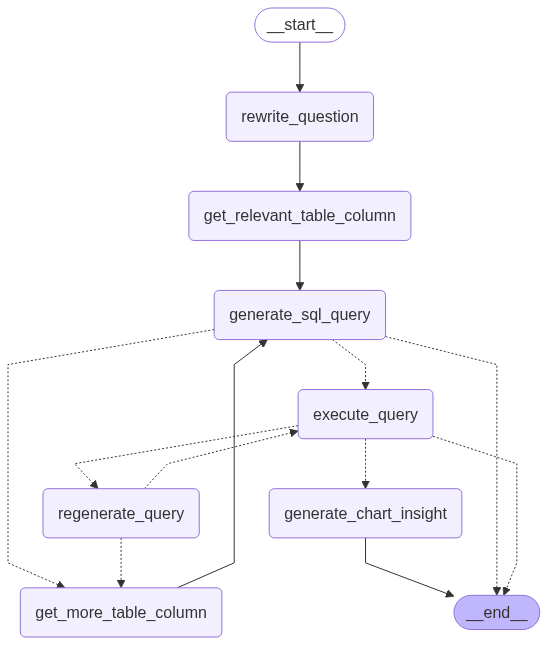

In [65]:
# ans = graph.get_graph().draw_mermaid()
display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
message = [HumanMessage(content= "What is the number of students in each batch year wise?")]
tables = ["students", "courses", "professors", "departments", "enrollments", "classrooms", "schedules", "grades", "assignments", "submissions", "clubs", "club_members"]

input_state = InputState(messages=message, tables=tables)


In [67]:
ans = graph.invoke(input=input_state)

Entering generate_chart_insight.....


AttributeError: 'AgentState' object has no attribute 'query_result'

In [68]:
ans


NameError: name 'ans' is not defined